In [244]:
from astropy.io import fits
from astropy.cosmology import Planck18
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
from scipy.optimize import Bounds

In [245]:
clust_number = 9
snap_number = 104

In [246]:
r500 = fits.getheader(f'/home2/ferragamo/NIKA2_300_TS/Raphael_maps/Xray_theoretical_maps_CL{clust_number:04d}_snap_{snap_number:03d}_proj_0.fits', ext=1)['R500']
r200 = fits.getheader(f'/home2/ferragamo/NIKA2_300_TS/Raphael_maps/Xray_theoretical_maps_CL{clust_number:04d}_snap_{snap_number:03d}_proj_0.fits', ext=1)['R200']
z = fits.getheader(f'/home2/ferragamo/NIKA2_300_TS/Raphael_maps/Xray_theoretical_maps_CL{clust_number:04d}_snap_{snap_number:03d}_proj_0.fits', ext=1)['REDSHIFT']
r500, r200, z

r200_frac = 2

In [247]:
true_leff = np.load(f'/data7/NIKA2-300th/rwicker/Weiguang_sph_tests/true_leff_map_CL{clust_number:04d}_snap{snap_number:03d}.npy')
high_pass_synth_leff = np.load(f'/data7/NIKA2-300th/rwicker/synthetic_leff_maps/synthetic_leff_map_CL{clust_number:04d}_snap{snap_number:03d}.npy')
splash_density = np.load(f'/data7/NIKA2-300th/rwicker/splash_density_maps/ne_map_CL{clust_number:04d}_snap{snap_number:03d}.npy')

In [248]:
npix = len(splash_density)
bin_size = 2*r200_frac*r200 / npix
print(npix, bin_size)

860 10.00739534883721


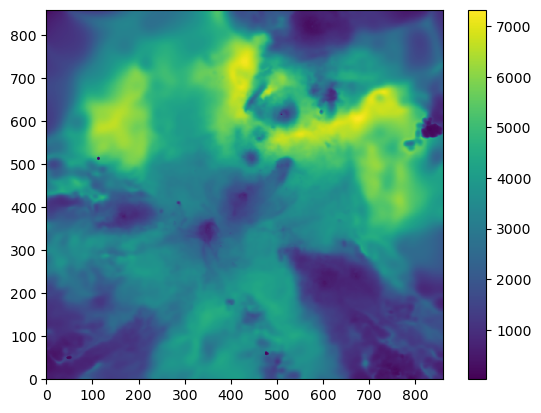

In [249]:
true_leff_map = plt.pcolormesh(true_leff)
plt.colorbar(true_leff_map)

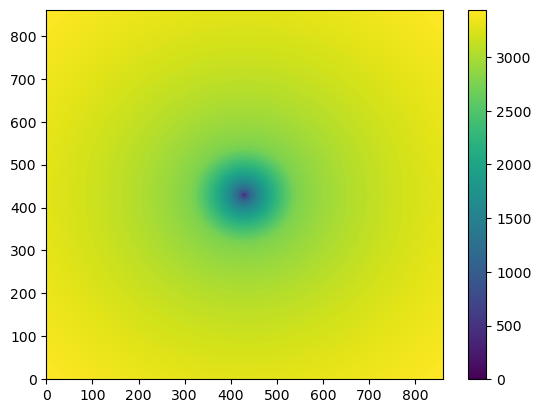

In [250]:
synth_leff_map = plt.pcolormesh(high_pass_synth_leff)
plt.colorbar(synth_leff_map)

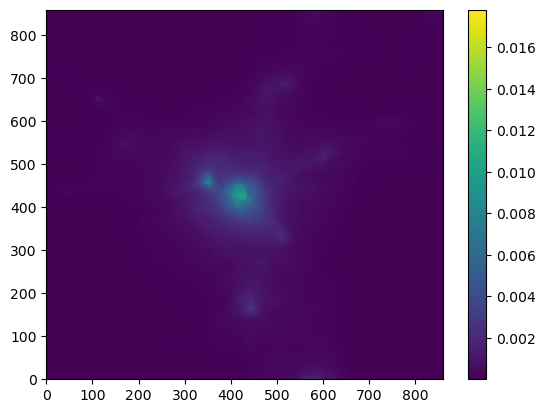

In [251]:
ne_map = plt.pcolormesh(splash_density)
plt.colorbar(ne_map)

In [252]:
nbin = 300
rbins_p = np.logspace(np.log10(0.005*r200), np.log10(r200_frac*r200), num=nbin+1)

xx, yy = np.meshgrid(np.linspace(-len(splash_density)//2*bin_size, len(splash_density)//2*bin_size, len(splash_density)),
                     np.linspace(-len(splash_density)//2*bin_size, len(splash_density)//2*bin_size, len(splash_density)))

dist = np.sqrt(xx**2 + yy**2)

/tmp/ipykernel_1011205/1793012181.py:4: RuntimeWarning: Mean of empty slice
  ne_prof = np.append(ne_prof, np.nanmean(splash_density[(dist>rr0) & (dist<=rr1)]))


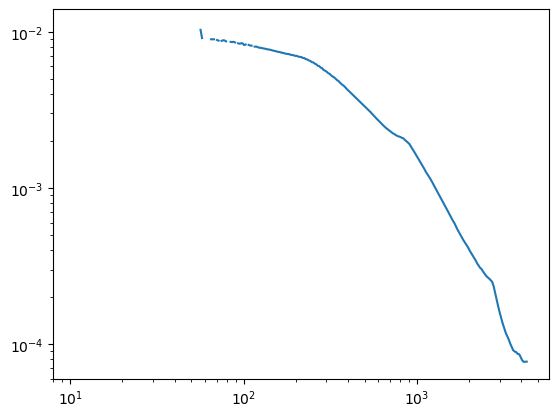

In [253]:
ne_prof = []
ne_prof.append(np.nanmean(splash_density[(dist<=rbins_p[0])]))
for i, (rr0, rr1) in enumerate(zip(rbins_p[:-1], rbins_p[1:])):
    ne_prof = np.append(ne_prof, np.nanmean(splash_density[(dist>rr0) & (dist<=rr1)]))

plt.loglog(rbins_p, ne_prof)

In [254]:
def beta_profile(r, n0, rc, b):
    return np.sqrt((n0**2)/(1+(r/rc)**2)**(3*b))

In [255]:
def vikhlinin_profile(r, n01, rc1, ra, alpha, beta1, epsilon, gamma, n02, rc2, beta2):
    return (n01**2 * (r/rc1)**(-alpha)*(1+(r/rc1)**2)**(alpha/2-3*beta1)*(1+(r/ra)**gamma)**(-epsilon/(2*gamma)) + (n02**2)/(1+(r/rc2)**2)**(3*beta2))**(1/2)

In [256]:
not_nan = np.where(~np.isnan(ne_prof))[0][1:]

In [257]:
popt_beta, pcov_beta = curve_fit(beta_profile, rbins_p[not_nan], ne_prof[not_nan])
popt_beta

/tmp/ipykernel_1011205/2160210839.py:2: RuntimeWarning: divide by zero encountered in divide
  return np.sqrt((n0**2)/(1+(r/rc)**2)**(3*b))
/tmp/ipykernel_1011205/2160210839.py:2: RuntimeWarning: overflow encountered in divide
  return np.sqrt((n0**2)/(1+(r/rc)**2)**(3*b))


array([9.38313170e-03, 2.80759924e+02, 4.78094430e-01])

In [258]:
lower_param_bounds = [1e-7, 1e-7*r500, 1e-3*r500, -5, -5, -5, 2.5, 1e-7, 1e-2*r500, 0]
upper_param_bounds = [1e-1, 1e-2*r500, 1e3*r500, 5, 5, 5, 3.5, 1e-1, 1e3*r500, 5]

In [259]:
popt_Vikhlinin, pcov_Vikhlinin = curve_fit(vikhlinin_profile, rbins_p[not_nan], ne_prof[not_nan], maxfev=5000000,
                                           bounds=Bounds(lower_param_bounds, upper_param_bounds))
popt_Vikhlinin

array([ 1.00443811e-02,  1.39633378e+01,  7.18609291e+02, -8.16810475e-01,
        1.10371264e-01,  5.00000000e+00,  3.50000000e+00,  6.95541060e-03,
        1.14982494e+03,  5.00000000e+00])

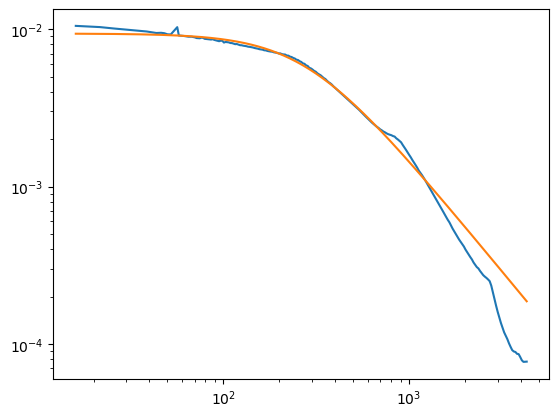

In [260]:
plt.loglog(rbins_p[not_nan], ne_prof[not_nan])
plt.loglog(rbins_p[not_nan], beta_profile(rbins_p[not_nan], *popt_beta))

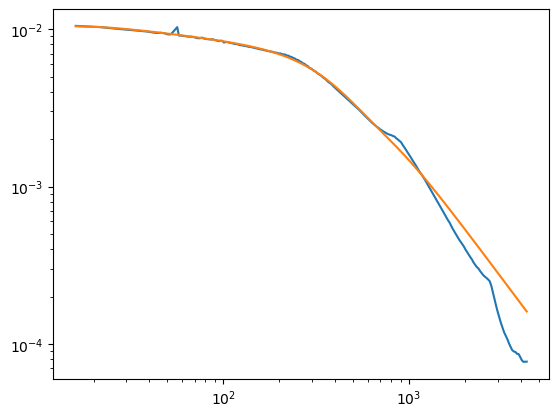

In [261]:
plt.loglog(rbins_p[not_nan], ne_prof[not_nan])
plt.loglog(rbins_p[not_nan], vikhlinin_profile(rbins_p[not_nan], *popt_Vikhlinin))

In [262]:
def centered_distance_cube(n):
    x,y,z = np.meshgrid(np.linspace(-2*r200, 2*r200, n), 
                        np.linspace(-2*r200, 2*r200, n),
                        np.linspace(-2*r200, 2*r200, n))
    return np.sqrt(x**2 + y**2 + z**2)

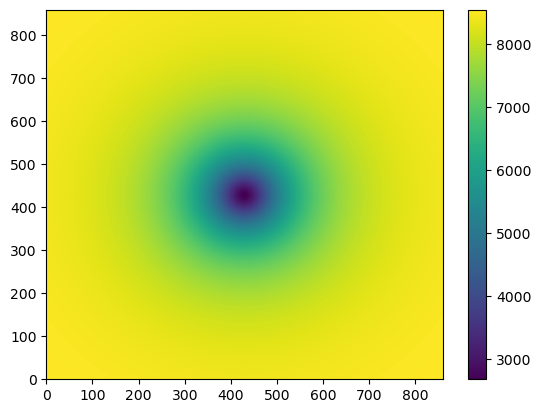

In [263]:
synthetic_beta_ne = beta_profile(centered_distance_cube(npix), *popt_beta)

synthetic_beta_leff = (np.sum(synthetic_beta_ne, axis=2)*bin_size)**2 / (np.sum(synthetic_beta_ne**2, axis=2)*bin_size)
synthetic_beta_leff_map = plt.pcolormesh(synthetic_beta_leff)
plt.colorbar(synthetic_beta_leff_map)

In [264]:
print(synthetic_beta_leff.shape)
np.save(f'/data7/NIKA2-300th/rwicker/synthetic_leff_maps/beta_ne_synth_leff_CL{clust_number:04d}_snap_{snap_number:03d}.npy', synthetic_beta_leff)

(860, 860)


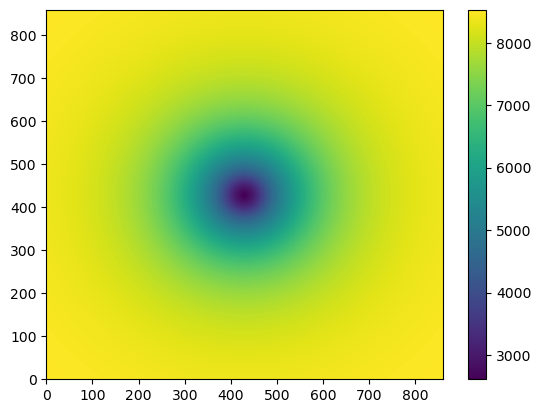

In [265]:
synthetic_vikhlinin_ne = vikhlinin_profile(centered_distance_cube(npix), *popt_Vikhlinin)

synthetic_vikhlinin_leff = (np.nansum(synthetic_vikhlinin_ne, axis=2)*bin_size)**2 / (np.nansum(synthetic_vikhlinin_ne**2, axis=2)*bin_size)
synthetic_vikhlinin_leff_map = plt.pcolormesh(synthetic_vikhlinin_leff)
plt.colorbar(synthetic_vikhlinin_leff_map)

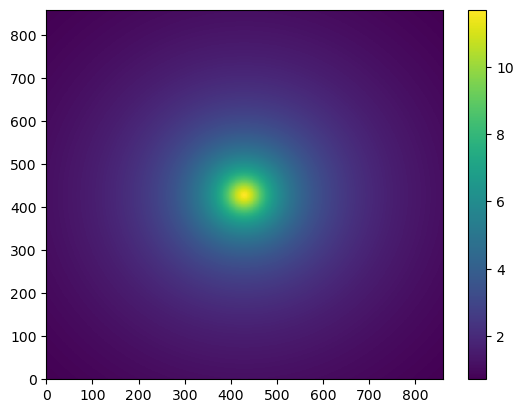

In [266]:
test_map = plt.pcolormesh(np.nansum(synthetic_vikhlinin_ne, axis=2)*bin_size)
plt.colorbar(test_map)

In [267]:
print(synthetic_vikhlinin_leff.shape)
np.save(f'/data7/NIKA2-300th/rwicker/synthetic_leff_maps/vikhlinin_ne_synth_leff_CL{clust_number:04d}_snap_{snap_number:03d}.npy', synthetic_vikhlinin_leff)

(860, 860)
